## Project: Vehicle Detection and Tracking
---


## Goals:

The goals / steps of this project are the following:

(1) Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

(2) Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

(3) Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

(4) Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

(5) Run your pipeline on a video stream (start with the testvideo.mp4 and later implement on full projectvideo.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
 
(6) Estimate a bounding box for vehicles detected.

In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
import cv2
from collections import namedtuple
import scipy.misc
from skimage import exposure
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from helpers import *
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## (1) Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images


### Configure default HOG parameters

In [3]:
hog_params = namedtuple('HOG_PARAMS', 'color_space' 'channel' 'orientations' 'pixels_per_cell' 'cells_per_block' 'visualise' 'feature_vector' 'spatial_size' 'hist_bins')
hog_params.orientations = 9
hog_params.color_space = 'YCrCb'
hog_params.pixels_per_cell = 8
hog_params.cells_per_block = 2
hog_params.visualise = True
hog_params.feature_vector = True
hog_params.channel = 'ALL'
hog_params.hist_bins = 32
hog_params.spatial_size = (32, 32)

### Test images

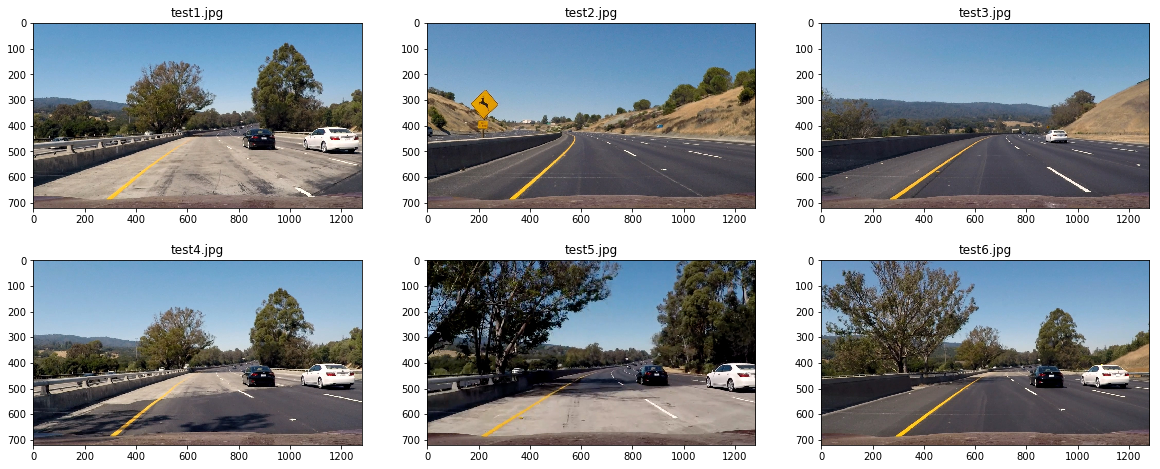

In [4]:
# Read in a calibration image
images = glob.glob('./test_images/test*.jpg')
plotimages(images, 2, 3, figh=8)

### Apply HOG and display results. Reference: [helpers.get_hog_features](./helpers.py)

In [5]:
for fname in images:
    # read the image
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, h_img = get_hog_features(gray,  hog_params.orientations, hog_params.pixels_per_cell, hog_params.cells_per_block,\
                    hog_params.visualise, hog_params.feature_vector)
    
    ## rescale intensity
    h_img = exposure.rescale_intensity(h_img, out_range=(0, 255))
    h_img = h_img.astype("uint8")
    scipy.misc.imsave("./output_images/HOG/HOG_"+fname.split("/")[-1], h_img)


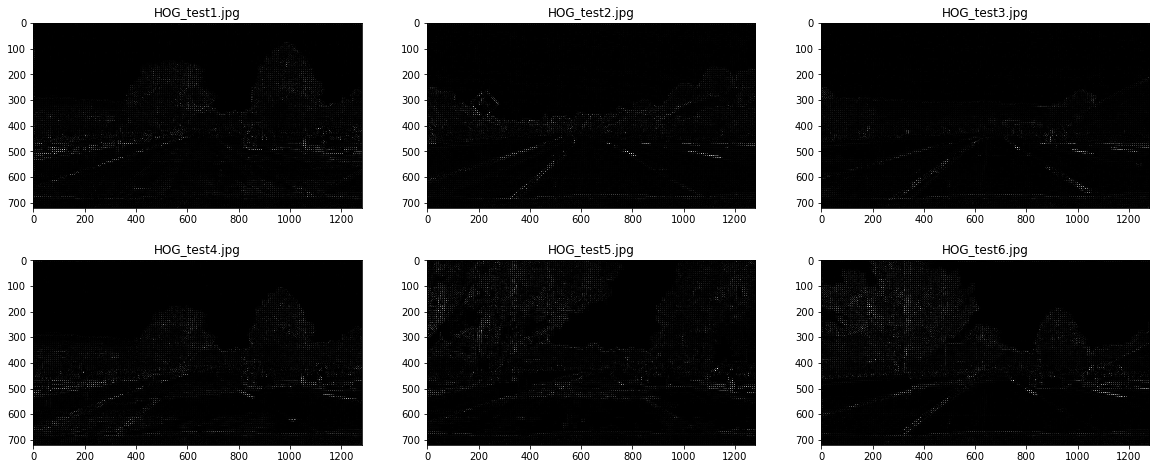

In [6]:
hog_images = glob.glob('./output_images/HOG/HOG_test*.jpg')
plotimages(hog_images, 2, 3, figh=8, gray=True)

## (1) Train a classifier Linear SVM classifier. Reference: [helpers.extract_features](./helpers.py), [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

- **Without Applying color transforming nor appending binned color features, nor histograms of color, to the HOG feature vector. Reference: call of [helpers.extract_features](./helpers.py) with parameters *spatial_feat=False, hist_feat=False* **

- **Feature normalizing and random selection for training and testing features. Reference: [X_scaler.transform (...)](.), [train_test_split (...)](.)**

In [7]:
cars = glob.glob('./set_vehicles/*.jpeg')
notcars = glob.glob('./set_non_vehicles/*.jpeg')

sample_size = 1000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

## feature extracting
car_features = extract_features(cars, color_space=hog_params.color_space, 
                        spatial_size=hog_params.spatial_size, hist_bins=hog_params.hist_bins, 
                        orient=hog_params.orientations, pix_per_cell=hog_params.pixels_per_cell, 
                        cell_per_block=hog_params.cells_per_block, 
                        hog_channel=hog_params.channel, spatial_feat=False, 
                        hist_feat=False)

notcar_features = extract_features(notcars, color_space=hog_params.color_space, 
                        spatial_size=hog_params.spatial_size, hist_bins=hog_params.hist_bins, 
                        orient=hog_params.orientations, pix_per_cell=hog_params.pixels_per_cell, 
                        cell_per_block=hog_params.cells_per_block, 
                        hog_channel=hog_params.channel, spatial_feat=False, 
                        hist_feat=False)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)    

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)


# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training (80%) and test sets (20%)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

## Declare the Support vector machine classifier
svc = LinearSVC()
svc.fit(X_train, y_train)

n_predict = 15
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
#print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
#print('For these', n_predict, 'labels: ', y_test[0:n_predict])

del X
del X_scaler
del svc
del scaled_X
del X_train
del X_test
del y_train
del y_test

Test Accuracy of SVC =  0.96


## (2) & (3) Linear SVM Classifier. Reference: [helpers.extract_features](./helpers.py), [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

- **Apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.. Reference: call of [helpers.extract_features](./helpers.py) with parameters *spatial_feat=True, hist_feat=True* **

- **Feature normalizing and random selection for training and testing features. Reference: [X_scaler.transform (...)](.), [train_test_split (...)](.)**

In [8]:
car_features = extract_features(cars, color_space=hog_params.color_space, 
                        spatial_size=hog_params.spatial_size, hist_bins=hog_params.hist_bins, 
                        orient=hog_params.orientations, pix_per_cell=hog_params.pixels_per_cell, 
                        cell_per_block=hog_params.cells_per_block, 
                        hog_channel=hog_params.channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)

notcar_features = extract_features(notcars, color_space=hog_params.color_space, 
                        spatial_size=hog_params.spatial_size, hist_bins=hog_params.hist_bins, 
                        orient=hog_params.orientations, pix_per_cell=hog_params.pixels_per_cell, 
                        cell_per_block=hog_params.cells_per_block, 
                        hog_channel=hog_params.channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)

X = np.vstack((car_features, notcar_features)).astype(np.float64)        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])


Test Accuracy of SVC =  0.9925
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.]
For these 15 labels:  [ 1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.]


## (4) Implement a sliding-window technique and use your trained classifier to search for vehicles in images. Reference [helpers.find_cars](./helpers.py), [vehicle_tracker::pipeline](.)

## (6) Estimate a bounding box for vehicles detected. Reference [vehicle_tracker::pipeline](.)

In [9]:
MIN_VALID_FRAMES = 15
from functools import reduce

class vehicle_tracker():
    def __init__(self, regions, hog_params, svc, X_scaler, threshold):
        self.svc = svc
        self.X_scaler = X_scaler        
        self.hog_params = hog_params
        self.regions = regions
        self.threshold = threshold
        self.framecounter = 0
        self.last_labels = None
        self.heat = None
        self.heat_container = []
    
    def process_heat(self):
        if self.framecounter < MIN_VALID_FRAMES:
            return
        self.heat = reduce((lambda x, y: x + y), self.heat_container[-MIN_VALID_FRAMES:])
        
        
    def pipeline(self, image, display_heat=False, single_image=False):
        self.framecounter += 1
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        boxes = find_cars(image, self.regions, self.svc, self.X_scaler,\
                       self.hog_params.orientations, self.hog_params.pixels_per_cell,\
                       self.hog_params.cells_per_block, self.hog_params.spatial_size, self.hog_params.hist_bins)
        
        # Add heat to each box in box list   
        heat = add_heat(heat, boxes)
        self.heat_container.append(heat)
        
    
        if single_image:
            # Apply threshold to help remove false positives
            thresholded_heat=apply_threshold(heat, self.threshold)
            # Visualize the heatmap when displaying 
            heatmap = np.clip(thresholded_heat, 0, 255)
            # Find final boxes from heatmap using label function
            labels = label(heatmap)
            # draw boxes oon imge directly
            draw_img = draw_labeled_bboxes(np.copy(image), labels)
        else:
            draw_img = np.copy(image)

            ## Every last MIN_VALID_FRAMES do:
            #if self.framecounter >= MIN_VALID_FRAMES:
            ## Every MIN_VALID_FRAMES do:
            if self.framecounter % MIN_VALID_FRAMES == 0:
                
                # Generate the heatmap for the last MIN_VALID_FRAMES frames
                self.process_heat()
                
                # Apply threshold to help remove false positives
                thresholded_heat=apply_threshold(self.heat, self.threshold)
                # get the heatmap
                heatmap = np.clip(thresholded_heat, 0, 255)
                # Find final boxes from heatmap using label function
                self.last_labels = label(heatmap)
                # draw the labeled boxes
                draw_img = draw_labeled_bboxes(np.copy(image), self.last_labels)
                
            else:
                if self.last_labels is not None:
                    draw_img = draw_labeled_bboxes(np.copy(image), self.last_labels)
                
        if display_heat:
            fig = plt.figure(figsize=(20, 10))
            plt.subplot(221)
            plt.imshow(draw_boxes(np.copy(image), boxes))
            plt.title('Car Positions')
            plt.subplot(222)
            plt.imshow(heatmap, cmap='hot')
            plt.title('Heat Map')
            plt.subplot(223)
            plt.imshow(draw_img)            
            plt.title('Estimated bounding box for vehicles detected')
            fig.tight_layout()
            plt.show()
            
        return draw_img
    
    def __del__(self):
        del self.svc
        del self.X_scaler
        del self.hog_params
        del self.regions
        del self.threshold

### Defining multiple regions of interest with different scales 

In [10]:
# Define namedtuple for region definition
roi_1 = namedtuple('ROI', 'ymin' 'ymax' 'scale')
roi_1.ymin = 400
roi_1.ymax = 656
roi_1.scale = 1.3

roi_2 = namedtuple('ROI', 'ymin' 'ymax' 'scale')
roi_2.ymin = 400
roi_2.ymax = 656
roi_2.scale = 1.6

roi_3 = namedtuple('ROI', 'ymin' 'ymax' 'scale')
roi_3.ymin = 400
roi_3.ymax = 656
roi_3.scale = 1.9

roi_4 = namedtuple('ROI', 'ymin' 'ymax' 'scale')
roi_4.ymin = 400
roi_4.ymax = 656
roi_4.scale = 2.1

ROI = [roi_1, roi_2, roi_3, roi_4]

### Apply vehicle search on test images

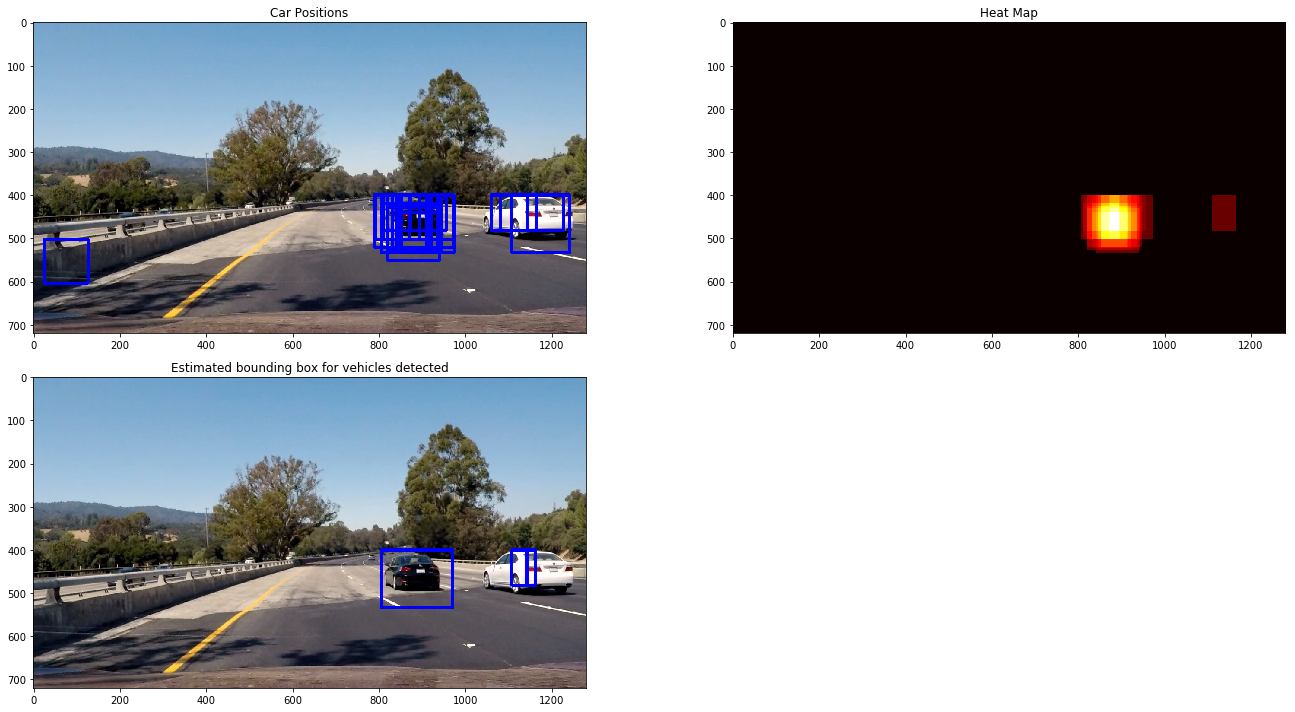

In [11]:
ct = vehicle_tracker(regions=ROI, hog_params=hog_params, svc=svc, X_scaler=X_scaler, threshold=2)
img = mpimg.imread('test_images/test4.jpg')
im = ct.pipeline(img, display_heat=True, single_image=True)
del ct

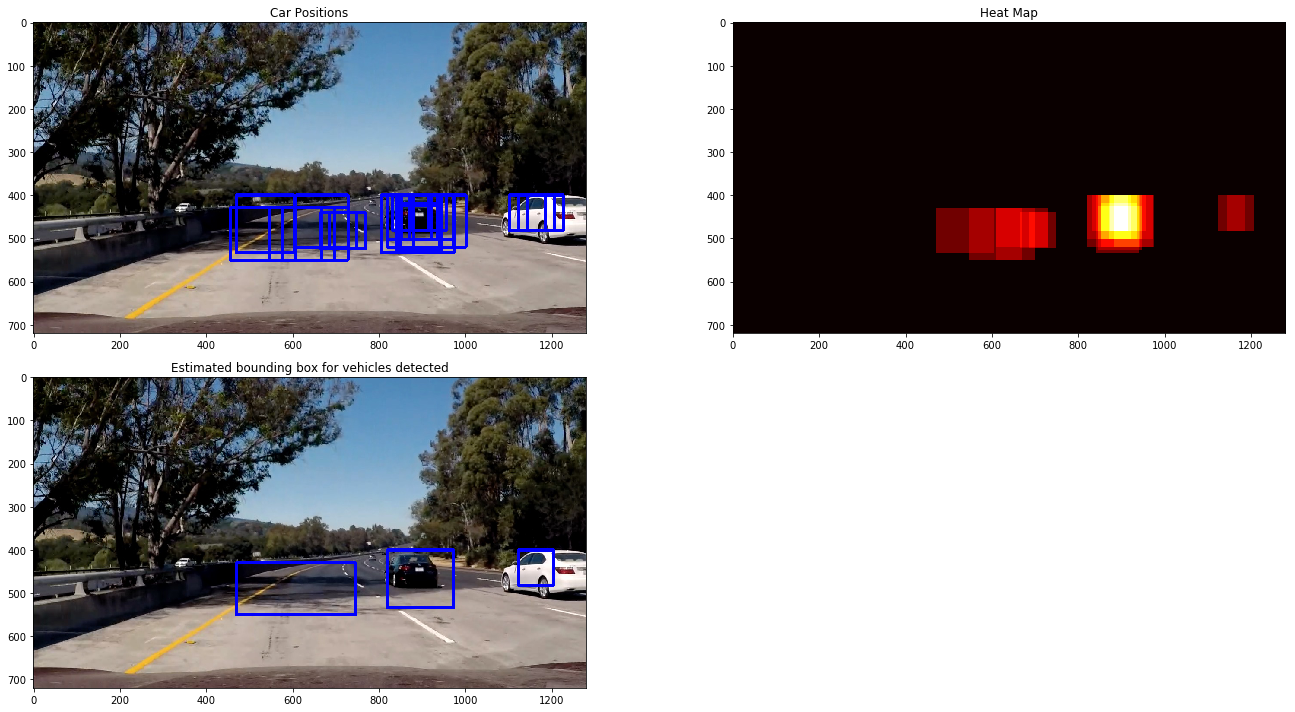

In [12]:
ct = vehicle_tracker(regions=ROI, hog_params=hog_params, svc=svc, X_scaler=X_scaler, threshold=1)
img = mpimg.imread('test_images/test5.jpg')
im = ct.pipeline(img, display_heat=True, single_image=True)
del ct

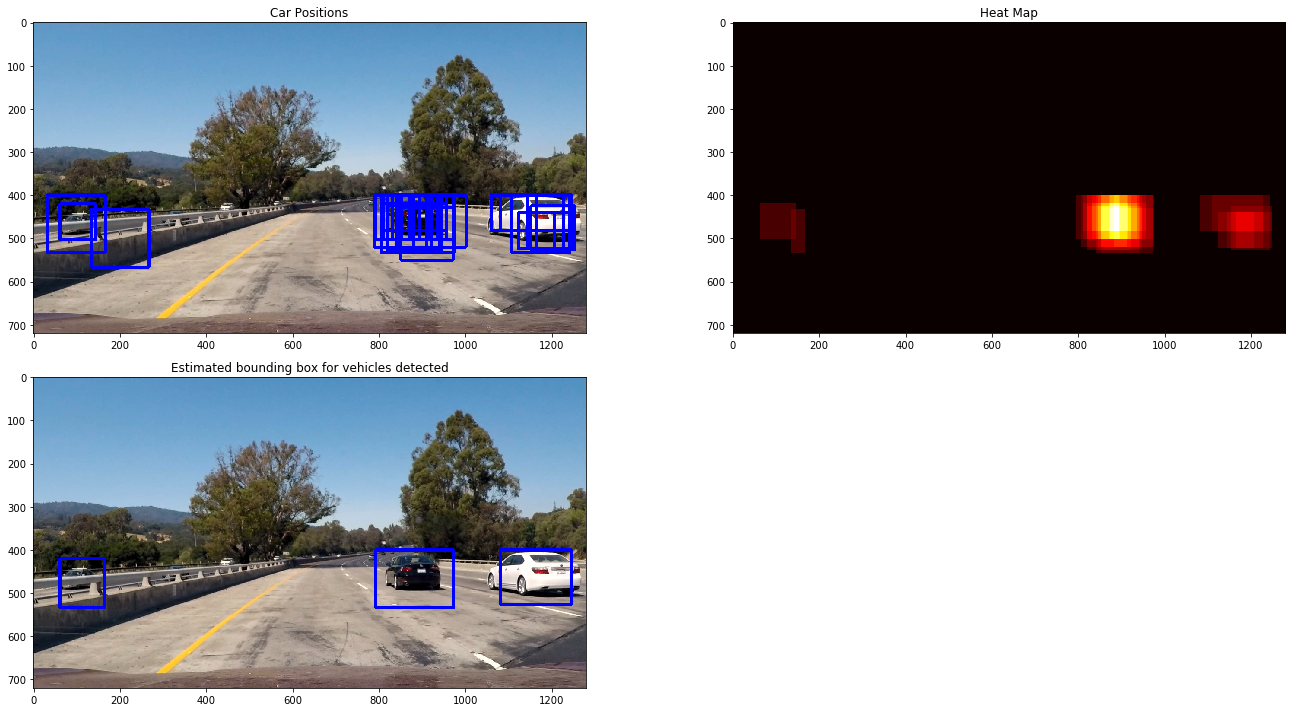

In [13]:
ct = vehicle_tracker(regions=ROI, hog_params=hog_params, svc=svc, X_scaler=X_scaler, threshold=1)
img = mpimg.imread('test_images/test1.jpg')
im = ct.pipeline(img, display_heat=True, single_image=True)
del ct

## (5) Run your pipeline on a video stream (start with the testvideo.mp4 and later implement on full projectvideo.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.


In [17]:
# render output video
#video_output = './output_images/test_video_output.mp4'
#clip1 = VideoFileClip("./test_video.mp4")

video_output = './output_images/project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

vhcle_tracker = vehicle_tracker(regions=ROI, hog_params=hog_params, svc=svc, X_scaler=X_scaler,\
                                    threshold=MIN_VALID_FRAMES*3+3)
video_clip = clip1.fl_image(vhcle_tracker.pipeline)
%time video_clip.write_videofile(video_output, audio=False)
del vhcle_tracker

[MoviePy] >>>> Building video ./output_images/project_video_output.mp4
[MoviePy] Writing video ./output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [26:14<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_output.mp4 

CPU times: user 1h 33min 8s, sys: 1min 2s, total: 1h 34min 11s
Wall time: 26min 15s


In [18]:
# play output video
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))